In [1]:
%matplotlib widget
from bmcs_cross_section.api import MKappa, TShape, MKappaParamsStudy, EC2, ReinfLayer, IShape, CustomShape, EC2ConcreteMatMod, EC2PlateauConcreteMatMod
from bmcs_beam.api import FourPBSystem, BoundaryConditions, BoundaryConfig, DeflectionProfile, BeamDesign, LoadDeflectionParamsStudy, SLSParamStudy, BeamSLSCurve
import numpy as np
import bmcs_utils.api as bu
import matplotlib.pyplot as plt

In [2]:
# Concrete C3-HF2-165-4
E_cm_C3 = 43596
f_cm_C3 = 103
fctm_sp = 5.6
fctm_fl = 12.51

In [3]:
# solidian REBAR Ø6 and Ø8
A_phi_6 = 28.2
A_phi_8 = 50.2

In [4]:
def get_dp(f_cm = f_cm_C3, E_cm = E_cm_C3, fctm_fl=None,
           setup='4pb', L=2000, L_F=None,
           high_kappa = 0.00018, concrete_law='EC2',
           B=200, H=150, A = None,
           reinf = 'carbon',
           E_nm=None, f_t=None, z=None,
           carbon_type='rebars',
           grid_layers_n=1, grid_layers_spacing=10, grid_layers_area=[]):
    # carbon_type: 'rebars' -> solidian REBAR Ø8-CCE
    # carbon_type: 'grid' -> solidian GRID Q95-CCE-38-E5
    
    mc = MKappa(low_kappa = 0, high_kappa = high_kappa)
    
    mc.cs_design.matrix=concrete_law
    
    f_ck = EC2.get_f_ck_from_f_cm(f_cm)
    if fctm_fl is None:
        fctm_fl = EC2.get_f_ctm_fl(f_ck, H)
    if concrete_law == 'EC2 with plateau' or concrete_law == 'EC2':
        mc.cs_design.matrix_.trait_set(f_cm = f_cm)
    elif concrete_law == 'piecewise linear':
        mc.cs_design.matrix_.trait_set(
            eps_cy=EC2.get_eps_c3(f_ck),
            eps_cu=EC2.get_eps_cu3(f_ck),
        )
    
    mc.cs_design.matrix_.trait_set(E_cc=E_cm, 
                                   E_ct=E_cm, 
                                   eps_cr = fctm_fl/E_cm, 
                                   eps_tu = fctm_fl/E_cm,)

    mc.cross_section_shape_.B = B
    mc.cross_section_shape_.H = H

    if carbon_type == 'rebars':
        E_nm=158000 if E_nm is None else E_nm
        f_t=2500 if f_t is None else f_t
        if A is None:
            A = 3 * A_phi_8
        if z is None:
            z = 4 + 10
    elif carbon_type == 'grid':
        E_nm=230000 if E_nm is None else E_nm
        f_t=3300 if f_t is None else f_t
        
        spacing = 38
        rov_num = int(B/spacing) + 1
        rov_cs_area = 3.62

        if A is None:
            A = rov_num * rov_cs_area
        if z is None:
            z = 10
       
    d = H - z
    
    if reinf == 'carbon':
        if grid_layers_n == 1:
            bl1 = ReinfLayer(name=carbon_type, z=z, A=A, matmod='carbon')
            bl1.matmod_.trait_set(E=E_nm, f_t=f_t, factor = 1.)
            mc.cross_section_layout.add_layer(bl1)
        else:
            for i in range(grid_layers_n):
                if grid_layers_area:
                    bl1 = ReinfLayer(name=carbon_type, z=z + i*grid_layers_spacing, A=grid_layers_area[i], matmod='carbon')
                else:
                    bl1 = ReinfLayer(name=carbon_type, z=z + i*grid_layers_spacing, A=A, matmod='carbon')
                bl1.matmod_.trait_set(E=E_nm, f_t=f_t, factor = 1.)
                mc.cross_section_layout.add_layer(bl1)
            A = grid_layers_n * A
    else:
        bl1 = ReinfLayer(name='rebars', z=z, A=A, matmod='steel')
        mc.cross_section_layout.add_layer(bl1)

    rho = A/(B*d)
    print('A=', A)
    print(r'rho =', round(rho * 100, 2), r'%')
    # mechanical reinforcement ratio
#     w_m = A * f_t / (B * H * f_cm)
#     print('w_m:', w_m)

    dp = DeflectionProfile(mc=mc)
    
    if setup == '4pb':
        dp.beam_design.system = '4pb'
        if L_F is not None:
            print('L_F assigned!')
            dp.beam_design.system_.L_F = L_F
    elif setup == '3pb':
        dp.beam_design.system = '3pb'
    elif setup == 'dist':
        dp.beam_design.system = 'simple_beam_dist_load'
        
    dp.beam_design.system_.L = L
    
    print('l/d =', dp.beam_design.system_.L/d)
    
    return dp

In [5]:
get_dp().interact()

A= 150.60000000000002
rho = 0.55 %
l/d = 14.705882352941176
V_Rm_c = 35.9 kN, Shear failure by F_tot_max = 71.8 kN


## Grid data

In [6]:
grid_data = dict(high_kappa =0.0003, B=300, H=100, carbon_type = 'grid', concrete_law = 'EC2', L=1800)
dp = get_dp(**grid_data)
# sls = BeamSLSCurve(n_i = 12, dp=dp)
dp.interact()
# sls.run()
# sls.interact()

A= 28.96
rho = 0.11 %
l/d = 20.0
V_Rm_c = 20.74 kN, Shear failure by F_tot_max = 41.48 kN


In [7]:
# sls.plot_F_u()
sls.plot_F_u(bending_shear_diff = True)
# sls.plot_F_u(load='shear')


# Achse x: Bewehrungsgrad rho [%]
# Achse y: Biegeschlankheit l/d [-]

NameError: name 'sls' is not defined

## Grid 1 layer, 3PB

In [8]:
dp = get_dp(**grid_data, setup='3pb')
dp.interact()

A= 28.96
rho = 0.11 %
l/d = 20.0


## Grid 1 layer, 4pb loading

In [9]:
beton_stauchung_max = -1525*1e-6
beton_stauchung_max

-0.0015249999999999999

In [13]:
B_1_M_1 = dict(f_cm = 97.58, E_cm = 45208.51, fctm_fl=0.9*5.02)
dp = get_dp(**grid_data, setup='4pb', **B_1_M_1)
dp.interact()

A= 28.96
rho = 0.11 %
l/d = 20.0
V_Rm_c = 20.37 kN, Shear failure by F_tot_max = 40.74 kN


## Grid 1.5 layers

In [10]:
dp = get_dp(**grid_data, grid_layers_n=2, grid_layers_spacing=10, setup='4pb')

dp.mc.cross_section_layout.items[1].z = 20
dp.mc.cross_section_layout.items[1].A = 4 * 3.62 # 0.5 layer

dp.interact()

A= 57.92
rho = 0.21 %
l/d = 20.0
V_Rm_c = 20.74 kN, Shear failure by F_tot_max = 41.48 kN


V_Rm_c = 20.74 kN, Shear failure by F_tot_max = 41.48 kN


## Grid 3 layers, 4pb (shear failure!)

In [10]:
4130*1e-6

0.00413

In [8]:
# dp = get_dp(**grid_data, grid_layers_n=3, grid_layers_spacing=10, setup='4pb')
dp = get_dp(high_kappa =0.0003, B=200, H=80, carbon_type = 'grid', concrete_law = 'EC2', L=1800, grid_layers_n=3, grid_layers_spacing=10, setup='4pb')

dp.mc.cross_section_layout.items[1].z = 15
dp.mc.cross_section_layout.items[2].z = 20
# dp.mc.cross_section_layout.items[1].A = 4 * 3.62 # 0.5 layer

# NOTE: Edit area of each layer to be 5*3.62 = 18.1 mm^2, because 6 layers fit but will not have concrete cover from the sides

dp.interact()

A= 65.16
rho = 0.47 %
l/d = 25.714285714285715
V_Rm_c = 10.67 kN, Shear failure by F_tot_max = 21.34 kN


## Grid 0.5 layer + 2 steel rebars, 4pb loading

In [15]:
dp = get_dp(**grid_data, setup='4pb', z=20, A=4*3.62)

bl1 = ReinfLayer(name='steel', z=14, A=2*np.pi * (4**2), matmod='steel')
dp.mc.cross_section_layout.add_layer(bl1)

dp.interact()

A= 14.48
rho = 0.06 %
l/d = 22.5
V_Rm_c = 14.33 kN, Shear failure by F_tot_max = 28.66 kN


## 4 Steel rebars, 4pb

In [14]:
dp = get_dp(high_kappa =0.0003, B=300, H=100, setup='4pb', reinf = 'steel', concrete_law = 'EC2', L=1800, A=4*np.pi * (4**2), z=14)
dp.interact()

A= 201.06192982974676
rho = 0.78 %
l/d = 20.930232558139537


## Verify anchorage length
(to ensure no pull-out failure would happen before bending failure when a crack near the support appears)

(verification was done for one representative test for steel and for carbon)

### Steel

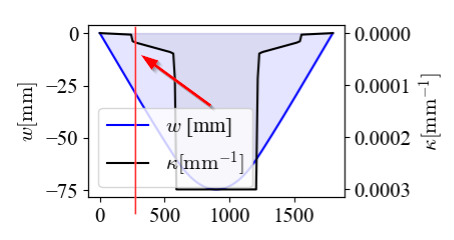

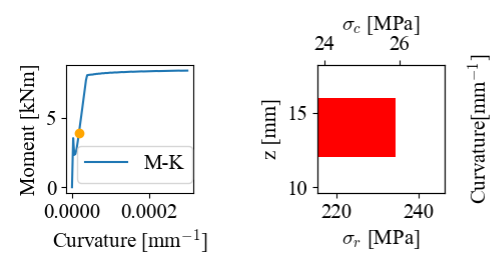

**Bond strength: Pullout failure**

In [25]:
tau_bmax = 1.25 * np.sqrt(100)
tau_bmax

12.5

**Bond strength: Splitting failure (if not enough concrete cover is provided)**

In [26]:
eta_2 = 0.7
f_cm = 100
phi = 8
c_min = 10
c_max = 30
k_m = 0 # no stirrups
K_tr = 0 # no stirrups
tau_bu_split = eta_2  * 6.5 * (f_cm/25)**0.25 * (25/phi)**0.2 * ((c_min/phi)**0.33*(c_max/c_min)**0.1 + k_m*K_tr)
tau_bu_split # [N/mm^2]

9.709320308038208

**Verification: Applied pullout force (force at cracked zone begin) vs Anchorage force**

In [29]:
reinf_stress_at_cracked_zone_begin = 240
applied_pullout_force = reinf_stress_at_cracked_zone_begin * np.pi * (phi/2)**2
extension_beyond_support = 100
support_to_cracked_zone = 150 # from kappa along beam diagram (safe estimate for 250 mm from diagram)
L_anchorage = extension_beyond_support + support_to_cracked_zone
n_bars = 4
anchorage_force = n_bars * L_anchorage * np.pi* phi * tau_bu_split
applied_pullout_force/anchorage_force # if < 1 no pull-out will happen

0.04943703418689512

### Carbon

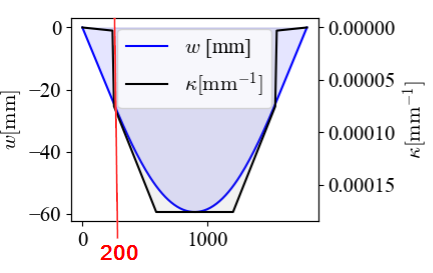
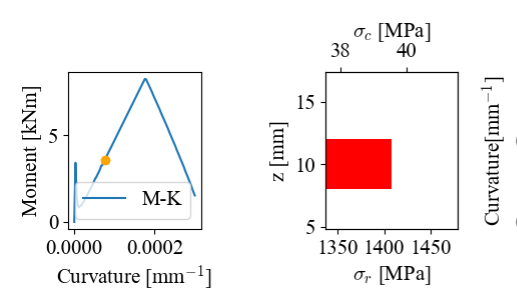

**Bond strength: Pullout failure**
(according to SPO tests \\fileserver...\02.3_SPO_Einaxialer Textilauszugsversuch)

In [36]:
tau_bmax_strand = 6600 / 114 # pullout force / bond length [N/mm]
tau_bmax_strand

57.89473684210526

**Verification: Applied pullout force (force at cracked zone begin) vs Anchorage force**

In [40]:
reinf_stress_at_cracked_zone_begin = 1400
applied_pullout_force = reinf_stress_at_cracked_zone_begin * 3.62 * 8 # 8 strands with 3.62 mm^2 each
print('applied_pullout_force:', applied_pullout_force/1000)
extension_beyond_support = 100
support_to_cracked_zone = 150 # from kappa along beam diagram (safe estimate for 200 mm from diagram)
L_anchorage = extension_beyond_support + support_to_cracked_zone
n_strands = 8
anchorage_force = n_strands * L_anchorage * tau_bmax_strand
print('anchorage_force:', anchorage_force/1000)
applied_pullout_force/anchorage_force # if < 1 no pull-out will happen

applied_pullout_force: 40.544
anchorage_force: 115.78947368421052


0.3501527272727273

# Additional studies (not used)

## I beam

In [25]:
# I section

dp = get_dp(high_kappa =0.00015, B=70, H=100, carbon_type = 'grid', concrete_law = 'EC2', L=1800, grid_layers_n=5, grid_layers_spacing=36.2, setup='4pb')

dp.mc.cross_section_layout.items[0].A = 30

dp.mc.cross_section_shape = 'I-shape'
dp.mc.cross_section_shape_.H = 200
dp.mc.cross_section_shape_.B_w = 70
dp.mc.cross_section_shape_.B_f_bot = 70
dp.mc.cross_section_shape_.B_f_top = 200
dp.mc.cross_section_shape_.H_f_bot = 50
dp.mc.cross_section_shape_.H_f_top = 50

dp.interact()

A= 36.2
rho = 0.57 %
l/d = 20.0


## Ductility studies

In [128]:
# steel example
dp = get_dp(high_kappa = 0.00013, B=200, H=100, A = 2 * np.pi * (4**2), L=1300, reinf='steel') # 'EC2 with plateau', 'piecewise linear'
dp.interact()

A= 100.53096491487338
rho = 0.58 %
l/d = 15.116279069767442


In [132]:
# carbon
dp = get_dp(high_kappa = 0.00025, B=200, H=100, A = 2 * A_phi_8, L=1300) # 'EC2 with plateau', 'piecewise linear'

dp.interact()

A= 100.4
rho = 0.58 %
l/d = 15.116279069767442
V_Rm_c = 24.64 kN, Shear failure by F_tot_max = 49.28 kN


In [133]:
# carbon and steel
dp = get_dp(high_kappa = 0.0003, B=200, H=100, A = 1 * A_phi_8, concrete_law = 'EC2', L=1300) # 'EC2 with plateau', 'piecewise linear'

bl1 = ReinfLayer(name='rebars', z=14, A=2 * np.pi * (4**2), matmod='steel')
dp.mc.cross_section_layout.add_layer(bl1)

print('rho= ', str(3 * np.pi * (4**2)/(200*(100-14))*100))

dp.interact()

A= 50.2
rho = 0.29 %
l/d = 15.116279069767442
rho=  0.876723531234361
V_Rm_c = 19.55 kN, Shear failure by F_tot_max = 39.1 kN


In [102]:
# I section

dp = get_dp(high_kappa =0.00015, A = 2 * A_phi_6, L=1300)

dp.mc.cross_section_shape = 'I-shape'
dp.mc.cross_section_shape_.H = 200
dp.mc.cross_section_shape_.B_w = 50
dp.mc.cross_section_shape_.B_f_bot = 50
dp.mc.cross_section_shape_.B_f_top = 150
dp.mc.cross_section_shape_.H_f_bot = 50
dp.mc.cross_section_shape_.H_f_top = 50

dp.interact()

A= 56.4
rho = 0.21 %
l/d = 9.558823529411764


AttributeError: 'IShape' object has no attribute 'B'

In [81]:
# Rect section to compare with I

dp = get_dp(high_kappa = 0.00025, B=150, H=200, A = 2 * A_phi_6, L=1300) # 'EC2 with plateau', 'piecewise linear'

dp.interact()

A= 56.4
rho = 0.2 %
l/d = 6.989247311827957


In [135]:
# Ductile carbon beam
# grid_layers_area=list(1*np.linspace(0.1, 1, n))
# A =21.72
n=6
# dp = get_dp(high_kappa = 0.00013, B=150, H=200, L=1300, grid_layers_n=n, grid_layers_spacing=10, grid_layers_area=list(reversed([1, 3, 5, 8, 15, 30])))
dp = get_dp(high_kappa = 0.00013, B=150, H=200, L=1300, grid_layers_n=n, grid_layers_spacing=10, grid_layers_area=list([1, 3, 5, 8, 15, 30]))

# dp = get_dp(high_kappa = 0.00013, B=150, H=200, L=1300, carbon_type = 'grid', A=20)

# dp = get_dp(high_kappa = 0.00013, B=150, H=200, L=1300)

dp.interact()

A= 903.6000000000001
rho = 3.24 %
l/d = 6.989247311827957
V_Rm_c = 9.06 kN, Shear failure by F_tot_max = 18.12 kN


In [136]:
# Ductility study
# Beam: solidian REBAR Ø8-CCE
# failure on concrete compression
dp = get_dp(high_kappa = 0.0001, B=200, H=400, A = 2 * A_phi_8, concrete_law = 'EC2', L=1300) # 'EC2 with plateau', 'piecewise linear'

bl1 = ReinfLayer(name='rebars', z=30, A=1 * (3.14*8)**2, matmod='steel')
# bl1.matmod_.trait_set(E=E_nm, f_t=f_t, factor = 1.)
dp.mc.cross_section_layout.add_layer(bl1)

dp.interact()

A= 100.4
rho = 0.13 %
l/d = 3.3678756476683938
V_Rm_c = 81.29 kN, Shear failure by F_tot_max = 162.58 kN


In [36]:
# Ductility study 2
# Beam: solidian REBAR Ø8-CCE
# failure on concrete compression
dp = get_dp(high_kappa = 0.0001, B=200, H=400, A = 2 * A_phi_8, concrete_law = 'EC2', L=1300) # 'EC2 with plateau', 'piecewise linear'

bl1 = ReinfLayer(name='rebars', z=5, A=A_phi_8, matmod='carbon')
bl1.matmod_.trait_set(E=158000, f_t=2500/4)
dp.mc.cross_section_layout.add_layer(bl1)

dp.interact()

A= 100.4
rho = 0.13 %
l/d = 3.3678756476683938
V_Rm_c = 81.29 kN, Shear failure by F_tot_max = 162.58 kN


In [137]:
# Ductility study 3 on steel (over reinforced steel cross sections also have ductile behaviour if concrete is high)
dp = get_dp(f_ck = 40, high_kappa = 0.00002, B=200, H=400, A = 7*3.14*16**2, concrete_law = 'EC2', L=1300, reinf = 'steel') # 'EC2 with plateau', 'piecewise linear'
dp.interact()

TypeError: get_dp() got an unexpected keyword argument 'f_ck'